In [3]:
import os, getpass
from dotenv import load_dotenv

load_dotenv("../../.env")

True

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class RaceEngineer(BaseModel):
    team: str = Field(
        description="Primary F1 team affiliation of the engineer.",
    )
    name: str = Field(
        description="Name of the race engineer."
    )
    role: str = Field(
        description="Role of the engineer in the context of the race.",
    )
    focus: str = Field(
        description="Description of the engineer's focus, concerns, and strategic motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nTeam: {self.team}\nFocus: {self.focus}\n"

class StrategyTeam(BaseModel):
    engineers: List[RaceEngineer] = Field(
        description="Comprehensive list of race engineers with their roles and team affiliations.",
    )

class GenerateEngineersState(TypedDict):
    race_name: str
    max_engineers: int
    race_director_feedback: str
    engineers: List[RaceEngineer]

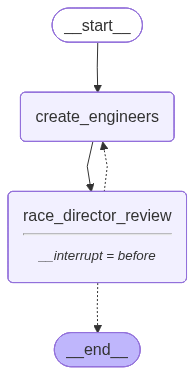

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

engineer_instructions="""You are tasked with creating a set of AI race engineer personas for an upcoming F1 race. Follow these instructions carefully:

1. First, review the research topic (the race):
{race_name}

2. Examine any editorial feedback that has been optionally provided to guide creation of the engineers:

{race_director_feedback}

3. Determine the most interesting strategic themes based upon the race and feedback above (e.g., tyre degradation, weather, fuel strategy).

4. Pick the top {max_engineers} themes.

5. Assign one race engineer to each theme, giving them a name, team, role, and specific focus."""

def create_engineers(state: GenerateEngineersState):
    """ Create race engineers """

    race_name=state['race_name']
    max_engineers=state['max_engineers']
    race_director_feedback=state.get('race_director_feedback', '')

    structured_llm = llm.with_structured_output(StrategyTeam)

    system_message = engineer_instructions.format(race_name=race_name,
                                                            race_director_feedback=race_director_feedback,
                                                            max_engineers=max_engineers)

    engineers = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of race engineers.")])

    return {"engineers": engineers.engineers}

def human_feedback(state: GenerateEngineersState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateEngineersState):
    """ Return the next node to execute """

    race_director_feedback=state.get('race_director_feedback', None)
    if race_director_feedback:
        return "create_engineers"

    return END

builder = StateGraph(GenerateEngineersState)
builder.add_node("create_engineers", create_engineers)
builder.add_node("race_director_review", human_feedback)
builder.add_edge(START, "create_engineers")
builder.add_edge("create_engineers", "race_director_review")
builder.add_conditional_edges("race_director_review", should_continue, ["create_engineers", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['race_director_review'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
max_engineers = 3
race_name = "The 2025 Monaco Grand Prix"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"race_name":race_name,"max_engineers":max_engineers,}, thread, stream_mode="values"):
    engineers = event.get('engineers', '')
    if engineers:
        for engineer in engineers:
            print(f"Name: {engineer.name}")
            print(f"Team: {engineer.team}")
            print(f"Role: {engineer.role}")
            print(f"Focus: {engineer.focus}")
            print("-" * 50)

Name: Luca Ferrari
Team: Mercedes
Role: Tire Strategy Engineer
Focus: Monitoring tire degradation rates on the tight Monaco circuit to optimize pit stop timing and tire compound choices.
--------------------------------------------------
Name: Sofia Martinez
Team: Red Bull
Role: Weather Strategy Specialist
Focus: Assessing weather patterns and potential rain impacts to advise on wet vs. dry tire strategies and timing of pit stops.
--------------------------------------------------
Name: Marco Rossi
Team: Ferrari
Role: Fuel Strategy Coordinator
Focus: Managing fuel load strategies to balance performance and safety, especially considering Monaco's limited overtaking opportunities and the need for precise fuel management.
--------------------------------------------------


In [8]:
state = graph.get_state(thread)
state.next

('race_director_review',)

In [9]:
graph.update_state(thread, {"race_director_feedback":
                            "Add a data scientist focused on historical performance at this track."}, as_node="race_director_review")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b60ad-a8aa-6a56-8002-1622f262ca44'}}

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    engineers = event.get('engineers', '')
    if engineers:
        for engineer in engineers:
            print(f"Name: {engineer.name}")
            print(f"Team: {engineer.team}")
            print(f"Role: {engineer.role}")
            print(f"Focus: {engineer.focus}")
            print("-" * 50)

Name: Luca Ferrari
Team: Mercedes
Role: Tire Strategy Engineer
Focus: Monitoring tire degradation rates on the tight Monaco circuit to optimize pit stop timing and tire compound choices.
--------------------------------------------------
Name: Sofia Martinez
Team: Red Bull
Role: Weather Strategy Specialist
Focus: Assessing weather patterns and potential rain impacts to advise on wet vs. dry tire strategies and timing of pit stops.
--------------------------------------------------
Name: Marco Rossi
Team: Ferrari
Role: Fuel Strategy Coordinator
Focus: Managing fuel load strategies to balance performance and safety, especially considering Monaco's limited overtaking opportunities and the need for precise fuel management.
--------------------------------------------------
Name: Liam Carter
Team: Mercedes
Role: Tire Degradation Specialist
Focus: Monitor tire wear rates and degradation patterns to optimize pit stop timing and tire compound choices, especially considering Monaco's tight circ

In [11]:
further_feedack = None
graph.update_state(thread, {"race_director_feedback":
                            further_feedack}, as_node="race_director_review")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b60ad-c04b-6778-8004-c27360c41f7c'}}

In [12]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
engineers = final_state.values.get('engineers')

In [14]:
final_state.next

()

In [15]:
for engineer in engineers:
    print(f"Name: {engineer.name}")
    print(f"Team: {engineer.team}")
    print(f"Role: {engineer.role}")
    print(f"Focus: {engineer.focus}")
    print("-" * 50)

Name: Liam Carter
Team: Mercedes
Role: Tire Degradation Specialist
Focus: Monitor tire wear rates and degradation patterns to optimize pit stop timing and tire compound choices, especially considering Monaco's tight circuit and limited overtaking opportunities.
--------------------------------------------------
Name: Sofia Martinez
Team: Red Bull
Role: Weather and Track Conditions Analyst
Focus: Assess weather forecasts and track temperature fluctuations to adapt strategies for potential rain or temperature shifts, which could impact tire performance and car setup.
--------------------------------------------------
Name: Marco Rossi
Team: Ferrari
Role: Historical Performance Data Scientist
Focus: Analyze historical race data at Monaco to identify patterns and strategies that have led to success or failure, informing current race tactics and qualifying approaches.
--------------------------------------------------


In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class StrategySimState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    engineer: RaceEngineer
    simulation_log: str
    strategy_memos: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are a Race Engineer tasked with interviewing a Race Simulator AI to develop a strategy for an upcoming race.

Your goal is to extract interesting and specific insights related to your strategic focus.

1. Interesting: Insights that are non-obvious (e.g., "undercut is powerful on lap 22").

2. Specific: Insights that avoid generalities and include specific data from the simulator (e.g., "5-second loss per lap on worn softs").

Here is your strategic focus and persona: {persona}

Begin by introducing yourself and then ask your first question.

Continue to ask questions to drill down and refine your understanding of the strategy.

When you are satisfied with your understanding, complete the interview with: "Thank you, that's all the data I need."

Remember to stay in character throughout your response."""

def generate_strategy_question(state: StrategySimState):
    """ Node to generate a strategy question """
    engineer = state["engineer"]
    messages = state["messages"]

    system_message = question_instructions.format(persona=engineer.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    return {"messages": [question]}

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

/var/folders/1f/vl83__r51wd66hnxlnlgncx00000gn/T/ipykernel_2064/596536740.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [19]:
from langchain_community.document_loaders import WikipediaLoader

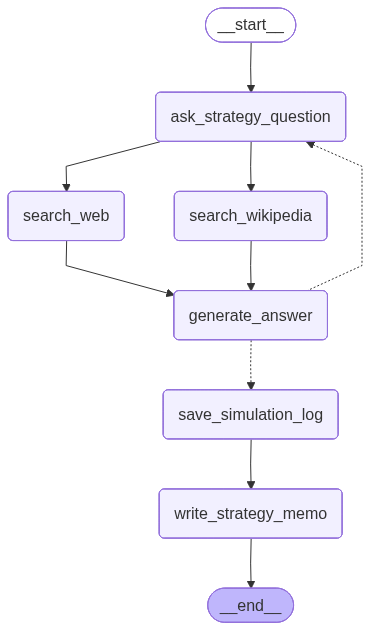

In [20]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between a race engineer and a simulator AI.

Your goal is to generate a well-structured query for use in retrieval and / or web-search for live data (like weather) or historical context related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the engineer.

Convert this final question into a well-structured web search query""")

def search_web(state: StrategySimState):

    """ Retrieve docs from web search (e.g., live weather) """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: StrategySimState):

    """ Retrieve docs from wikipedia (e.g., historical track data) """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are a Race Simulator AI being debriefed by a Race Engineer.

Here is the engineer's area of focus: {persona}.

You goal is to answer a question posed by the interviewer.

To answer the question, use this simulation data and context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: StrategySimState):

    """ Node to generate a simulation answer """

    engineer = state["engineer"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(persona=engineer.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "simulator"

    return {"messages": [answer]}

def save_simulation_log(state: StrategySimState):

    """ Save simulation log """

    messages = state["messages"]

    simulation_log = get_buffer_string(messages)

    return {"simulation_log": simulation_log}

def route_messages(state: StrategySimState,
                   name: str = "simulator"):

    """ Route simulation conversation """

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        return 'save_simulation_log'

    last_question = messages[-2]

    if "Thank you, that's all the data I need." in last_question.content:
        return 'save_simulation_log'
    return "ask_strategy_question"

section_writer_instructions = """You are an expert strategy analyst.

Your task is to create a short, easily digestible strategy memo based on a set of simulation data and context documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. ## [Strategy Memo Title]
b. ### [Key Insights]
c. ### [Data Sources]

4. Make your title engaging based upon the focus area of the engineer:
{persona}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the engineer
- Emphasize what is novel, interesting, or surprising about insights gathered from the simulation debrief
- Create a numbered list of source documents, as you use them
- Do not mention the names of engineers or the simulator
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Data Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Data Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_strategy_memo(state: StrategySimState):

    """ Node to write strategy memo """

    simulation_log = state["simulation_log"]
    context = state["context"]
    engineer = state["engineer"]

    system_message = section_writer_instructions.format(persona=engineer.persona)
    memo = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    return {"strategy_memos": [memo.content]}

sim_builder = StateGraph(StrategySimState)
sim_builder.add_node("ask_strategy_question", generate_strategy_question)
sim_builder.add_node("search_web", search_web)
sim_builder.add_node("search_wikipedia", search_wikipedia)
sim_builder.add_node("generate_answer", generate_answer)
sim_builder.add_node("save_simulation_log", save_simulation_log)
sim_builder.add_node("write_strategy_memo", write_strategy_memo)

sim_builder.add_edge(START, "ask_strategy_question")
sim_builder.add_edge("ask_strategy_question", "search_web")
sim_builder.add_edge("ask_strategy_question", "search_wikipedia")
sim_builder.add_edge("search_web", "generate_answer")
sim_builder.add_edge("search_wikipedia", "generate_answer")
sim_builder.add_conditional_edges("generate_answer", route_messages,['ask_strategy_question','save_simulation_log'])
sim_builder.add_edge("save_simulation_log", "write_strategy_memo")
sim_builder.add_edge("write_strategy_memo", END)

memory = MemorySaver()
sim_graph = sim_builder.compile(checkpointer=memory).with_config(run_name="Conduct Simulation Debrief")

display(Image(sim_graph.get_graph().draw_mermaid_png()))

In [21]:
# Pick one analyst
engineers[0]

RaceEngineer(team='Mercedes', name='Liam Carter', role='Tire Degradation Specialist', focus="Monitor tire wear rates and degradation patterns to optimize pit stop timing and tire compound choices, especially considering Monaco's tight circuit and limited overtaking opportunities.")

In [22]:
from IPython.display import Markdown
messages = [HumanMessage(f"Let's start the simulation debrief for {race_name}.")]
thread = {"configurable": {"thread_id": "1"}}
simulation = sim_graph.invoke({"engineer": engineers[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(simulation['strategy_memos'][0])

# Strategic Insights for Tire Management at Monaco: Optimizing Pit Stops and Compound Choices

## Key Insights

Monaco’s unique circuit layout, characterized by tight corners and limited overtaking opportunities, demands meticulous tire management to maximize race performance. The simulation data reveals several critical points that can inform strategic decisions:

1. **Tire Compound Characteristics and Degradation Patterns**:  
   - The soft tire compounds (C5 and C6) offer the fastest lap times due to their quick warm-up and high grip but suffer from rapid degradation, typically lasting only 15-20 laps. The ultra-soft C6, despite its initial speed advantage, has a notably narrow operating window with worse degradation and minimal grip increase, often lasting only about half a lap before performance drops significantly [1][2].  
   - Medium tires (C2) strike a balance, providing good durability (25-35 laps) and competitive lap times, making them a versatile choice for Monaco’s conditions. Hard tires (C0) are the most durable, capable of exceeding 40 laps, but their slower pace makes them less attractive unless a one-stop strategy is viable [1][2].

2. **Impact of Tire Degradation on Race Strategy**:  
   - Degradation reduces grip over time, leading to slower lap times and shorter stints. Managing this degradation is crucial, especially in Monaco, where overtaking is limited, and maintaining track position is vital [3].  
   - Fresh tires can outperform severely degraded softer compounds, emphasizing the importance of precise pit stop timing. Teams must weigh the benefits of early pit stops for fresh softs against the risk of losing track position, especially given the limited overtaking opportunities [3].

3. **Track-Specific Considerations**:  
   - Monaco’s abrasive surface and high lateral loads accelerate tire wear, making durability a key factor. The low degradation observed in recent races suggests that the new C6 soft compound may last longer than previous softs, potentially allowing for fewer stops [4].  
   - The recent rule change requiring at least three different tire sets per race increases strategic complexity, discouraging starting on mediums due to the need for multiple pit stops, and favoring soft or ultra-soft starts for shorter stints [4].

4. **Overtaking and Pit Stop Strategy**:  
   - Overtaking opportunities are limited, but strategic use of tire degradation and pit stops can create overtaking chances, especially if a driver can survive on soft tires longer than expected or capitalize on safety cars.  
   - The simulation indicates that aggressive soft tire runs early in the race, combined with well-timed pit stops, can help gain track position, especially if a safety car appears at the right moment [4].

In summary, Monaco’s strategic landscape favors a nuanced approach: leveraging the ultra-soft C6 for short, aggressive stints, balancing durability with performance, and timing pit stops to exploit safety cars or tire degradation patterns. Teams that optimize tire choice and pit timing will have a significant advantage in this challenging circuit.

## Data Sources
[1] https://www.youtube.com/watch?v=Wnsa-KKktQk  
[2] https://www.reddit.com/r/F1Technical/comments/1lbu2uy/how_are_medium_tires_faster_than_softs_in/  
[3] https://www.catapult.com/blog/how-tyre-degradation-affects-race-strategy  
[4] https://www.racefans.net/2025/05/22/how-will-f1s-new-monaco-tyre-rule-work-and-how-might-teams-try-to-exploit-it/

In [23]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class RaceStrategyState(TypedDict):
    race_name: str
    max_engineers: int
    race_director_feedback: str
    engineers: List[RaceEngineer]
    strategy_memos: Annotated[list, operator.add]
    pre_race_briefing: str
    strategy_summary: str
    final_recommendation: str
    final_strategy_report: str

/var/folders/1f/vl83__r51wd66hnxlnlgncx00000gn/T/ipykernel_2064/3088371665.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


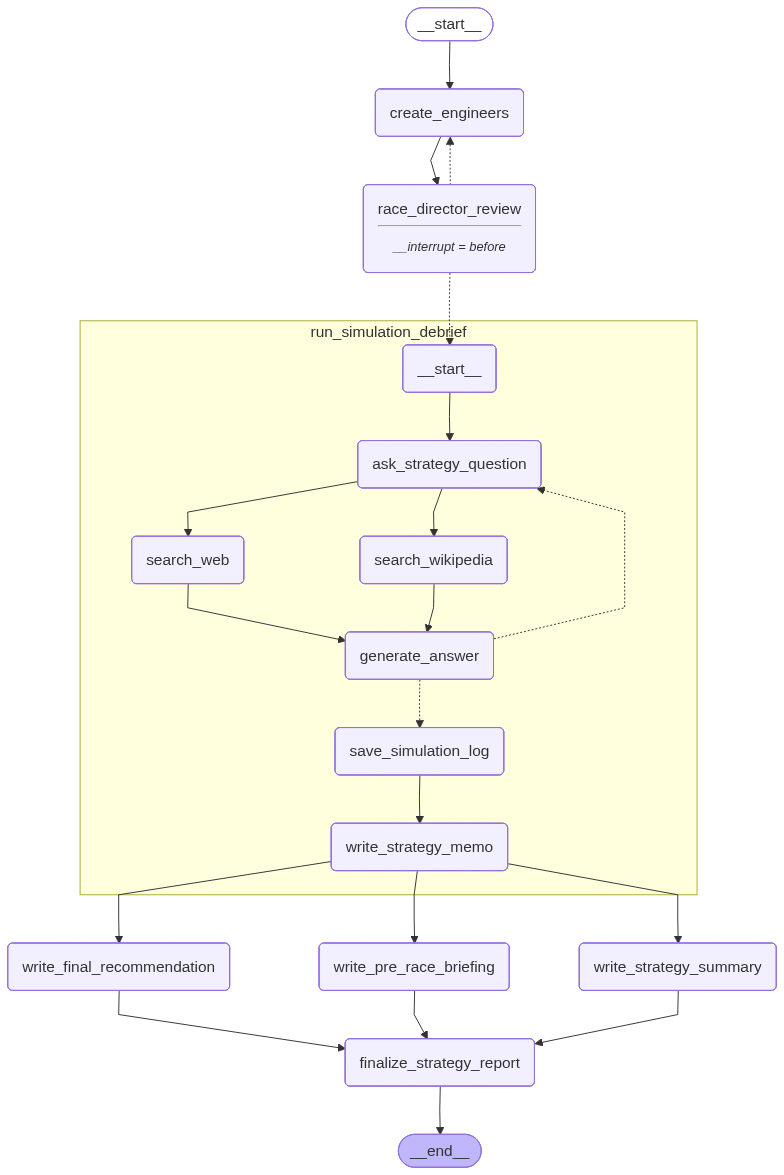

In [25]:
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

def initiate_all_simulations(state: RaceStrategyState):
    """ This is the "map" step where we run each simulation sub-graph using Send API """

    race_director_feedback=state.get('race_director_feedback')
    if race_director_feedback:
        return "create_engineers"

    else:
        race_name = state["race_name"]
        return [Send("run_simulation_debrief", {"engineer": engineer,
                                           "messages": [HumanMessage(
                                               content=f"Let's start the simulation debrief for {race_name}."
                                           )
                                                       ]}) for engineer in state["engineers"]]

report_writer_instructions = """You are a Lead Strategist creating a summary report for {race_name}

You have a team of race engineers. Each engineer has done two things:

1. They conducted an simulation debrief with an expert on a specific sub-topic.
2. They written up their findings into a strategy memo.

Your task:

1. You will be given a collection of memos from your engineers.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Strategy Summary
5. Do not mention any engineer names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Data Sources section with the `## Data Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the strategy memos from your engineers to build your report from:

{context}"""

def write_strategy_summary(state: RaceStrategyState):
    memos = state["strategy_memos"]
    race_name = state["race_name"]

    formatted_str_memos = "\n\n".join([f"{memo}" for memo in memos])

    system_message = report_writer_instructions.format(race_name=race_name, context=formatted_str_memos)
    summary = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"strategy_summary": summary.content}

intro_conclusion_instructions = """You are a Lead Strategist writing a briefing for the {race_name}

You will be given all of the strategy memos.

You job is to write a crisp and compelling pre-race briefing (introduction) or a final recommendation (conclusion) section.

The user will instruct you whether to write the briefing or recommendation.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for briefing) or recapping (for recommendation) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_pre_race_briefing(state: RaceStrategyState):
    memos = state["strategy_memos"]
    race_name = state["race_name"]

    formatted_str_memos = "\n\n".join([f"{memo}" for memo in memos])

    instructions = intro_conclusion_instructions.format(race_name=race_name, formatted_str_sections=formatted_str_memos)
    briefing = llm.invoke([instructions]+[HumanMessage(content=f"Write the pre-race briefing")])
    return {"pre_race_briefing": briefing.content}

def write_final_recommendation(state: RaceStrategyState):
    memos = state["strategy_memos"]
    race_name = state["race_name"]

    formatted_str_memos = "\n\n".join([f"{memo}" for memo in memos])

    instructions = intro_conclusion_instructions.format(race_name=race_name, formatted_str_sections=formatted_str_memos)
    recommendation = llm.invoke([instructions]+[HumanMessage(content=f"Write the final recommendation")])
    return {"final_recommendation": recommendation.content}

def finalize_strategy_report(state: RaceStrategyState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    summary = state["strategy_summary"]
    if summary.startswith("## Strategy Summary"):
        summary = summary.strip("## Strategy Summary")
    if "## Data Sources" in summary:
        try:
            summary, sources = summary.split("\n## Data Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["pre_race_briefing"] + "\n\n---\n\n" + summary + "\n\n---\n\n" + state["final_recommendation"]
    if sources is not None:
        final_report += "\n\n## Data Sources\n" + sources
    return {"final_strategy_report": final_report}

builder = StateGraph(RaceStrategyState)
builder.add_node("create_engineers", create_engineers)
builder.add_node("race_director_review", human_feedback)
builder.add_node("run_simulation_debrief", sim_graph) # <-- This is the corrected line
builder.add_node("write_strategy_summary",write_strategy_summary)
builder.add_node("write_pre_race_briefing",write_pre_race_briefing)
builder.add_node("write_final_recommendation",write_final_recommendation)
builder.add_node("finalize_strategy_report",finalize_strategy_report)

builder.add_edge(START, "create_engineers")
builder.add_edge("create_engineers", "race_director_review")
builder.add_conditional_edges("race_director_review", initiate_all_simulations, ["create_engineers", "run_simulation_debrief"])
builder.add_edge("run_simulation_debrief", "write_strategy_summary")
builder.add_edge("run_simulation_debrief", "write_pre_race_briefing")
builder.add_edge("run_simulation_debrief", "write_final_recommendation")
builder.add_edge(["write_final_recommendation", "write_strategy_summary", "write_pre_race_briefing"], "finalize_strategy_report")
builder.add_edge("finalize_strategy_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['race_director_review'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
max_engineers = 3
race_name = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"race_name":race_name,
                           "max_engineers":max_engineers},
                          thread,
                          stream_mode="values"):

    engineers = event.get('engineers', '')
    if engineers:
        for engineer in engineers:
            print(f"Name: {engineer.name}")
            print(f"Team: {engineer.team}")
            print(f"Role: {engineer.role}")
            print(f"Focus: {engineer.focus}")
            print("-" * 50)

Name: Alex Turner
Team: Mercedes
Role: Tire Strategy Engineer
Focus: Monitoring tire degradation and managing pit stops to optimize tire life and performance.
--------------------------------------------------
Name: Sofia Martinez
Team: Red Bull
Role: Weather and Track Conditions Engineer
Focus: Analyzing weather forecasts and track conditions to advise on optimal race pace and pit timing.
--------------------------------------------------
Name: Liam Chen
Team: Ferrari
Role: Fuel Strategy Engineer
Focus: Calculating fuel loads and managing fuel consumption strategies to ensure optimal race endurance and performance.
--------------------------------------------------


In [27]:
graph.update_state(thread, {"race_director_feedback":
                                "Add in a tyre degradation expert from Pirelli"}, as_node="race_director_review")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b60b3-ad62-6066-8002-bcee0845b1cd'}}

In [28]:
for event in graph.stream(None, thread, stream_mode="values"):
    engineers = event.get('engineers', '')
    if engineers:
        for engineer in engineers:
            print(f"Name: {engineer.name}")
            print(f"Team: {engineer.team}")
            print(f"Role: {engineer.role}")
            print(f"Focus: {engineer.focus}")
            print("-" * 50)

Name: Alex Turner
Team: Mercedes
Role: Tire Strategy Engineer
Focus: Monitoring tire degradation and managing pit stops to optimize tire life and performance.
--------------------------------------------------
Name: Sofia Martinez
Team: Red Bull
Role: Weather and Track Conditions Engineer
Focus: Analyzing weather forecasts and track conditions to advise on optimal race pace and pit timing.
--------------------------------------------------
Name: Liam Chen
Team: Ferrari
Role: Fuel Strategy Engineer
Focus: Calculating fuel loads and managing fuel consumption strategies to ensure optimal race endurance and performance.
--------------------------------------------------
Name: Alex Turner
Team: Mercedes
Role: Tire Degradation Specialist
Focus: Monitor tire wear and degradation patterns to optimize pit stop timing and tire choices, ensuring maximum grip and durability throughout the race.
--------------------------------------------------
Name: Sofia Martinez
Team: Red Bull
Role: Fuel Strate

In [29]:
graph.update_state(thread, {"race_director_feedback":
                            None}, as_node="race_director_review")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b60b3-d265-6f84-8004-0bb57b54aaff'}}

In [30]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
write_final_recommendation
--Node--
write_pre_race_briefing
--Node--
write_strategy_summary
--Node--
finalize_strategy_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_strategy_report')
Markdown(report)

# Unlocking Race Edge with LangGraph: The Future of Strategy

## Introduction

In the high-stakes world of Formula 1, strategic advantage hinges on advanced decision-making capabilities. This briefing previews how adopting LangGraph as an agent framework can revolutionize race strategies by enabling iterative, adaptive, and real-time decision processes. We explore its support for cyclical workflows, multi-agent collaboration, and seamless integration with telemetry data—empowering teams to optimize tire management, fuel loads, and overall race execution. Leveraging these cutting-edge tools promises a transformative edge, turning complex data into actionable insights and elevating race performance to new heights.

---



The adoption of LangGraph as an agent framework offers transformative benefits across multiple facets of race strategy, particularly in tire management, fuel load optimization, and dynamic decision-making processes. By leveraging its support for cyclical workflows, stateful interactions, and multi-agent orchestration, teams can transition from reactive to proactive, data-driven strategies that adapt seamlessly to the unpredictable and complex environment of Formula 1 racing.

In tire degradation management, LangGraph’s ability to facilitate iterative, looped analysis enables continuous refinement of tire wear predictions. Traditional linear models often fall short in capturing the non-linear, multi-mechanistic nature of tire wear, which involves thermal effects, abrasion, and sliding-induced degradation. The framework’s support for stateful workflows ensures that historical data and real-time telemetry are preserved across multiple cycles, allowing for nuanced, context-aware decision-making. This capability aligns with the need for ongoing assessment during a race, where conditions evolve rapidly, and strategic adjustments are critical [1][2][3].

Furthermore, the integration of machine learning models with multi-season telemetry data enhances predictive accuracy for tire lifespan and optimal pit stop timing. These models incorporate numerous performance indicators—such as temperature gradients, pressure variations, and compound-specific degradation rates—enabling precise, circuit-specific forecasts. Such predictive power surpasses traditional static models, providing real-time insights that inform proactive strategies rather than reactive responses [4][5][6].

Similarly, in fuel load management, LangGraph’s support for event-driven, cyclical workflows allows for iterative optimization of fuel strategies. Small variations in fuel weight significantly impact lap times and vehicle handling, with simulation data indicating that every 10 kg of additional fuel can add approximately 0.3 seconds to lap times [5]. The framework’s ability to respond dynamically to race events—such as safety car periods or environmental changes—ensures that fuel strategies remain flexible and optimized throughout the race. Real-time data analytics combined with precise control over agent interactions facilitate rapid adjustments, maximizing performance while managing safety and efficiency [1][2][3].

Finally, the framework’s capacity to model complex, non-linear dependencies through graph-based architectures supports comprehensive understanding and management of tyre physics and degradation mechanisms. This holistic approach enables teams to formulate nuanced strategies—such as timing pit stops for soft tires with rapid wear or leveraging safety car periods for optimal tyre changes—by continuously integrating telemetry data, environmental conditions, and physical insights [1][3].

In conclusion, LangGraph’s advanced agent capabilities—supporting cyclical workflows, state management, multi-agent orchestration, and real-time responsiveness—empower race teams to develop highly adaptive, predictive, and efficient strategies. This technological shift from reactive to proactive race management promises a significant competitive edge, optimizing performance, safety, and resource utilization in the demanding environment of Formula 1.


---

## Conclusion

Adopting LangGraph as an agent framework offers a transformative edge in race strategy optimization. Its support for cyclical workflows, robust state management, and seamless integration with telemetry data enables real-time, adaptive decision-making across tire and fuel management domains. By leveraging these capabilities, teams can develop predictive, context-aware systems that continuously refine strategies, respond swiftly to race dynamics, and maximize performance. Embracing LangGraph positions your organization at the forefront of data-driven racing innovation, ensuring a competitive advantage through smarter, more responsive race strategies.

## Data Sources

[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://docs.langchain.com/oss/python/langgraph/overview  
[3] https://www.3pillarglobal.com/insights/blog/comparison-crewai-langgraph-n8n/  
[4] https://www.raceteq.com/articles/2024/08/the-science-behind-tyre-degradation-in-formula-1  
[5] https://medium.com/formula-one-forever/underrated-stat-why-tire-wear-is-more-predictive-than-qualifying-c0cbf9f31231  
[6] https://en.wikipedia.org/wiki/Semantic_Web